<a href="https://colab.research.google.com/github/ekourkchi/Weather_research/blob/master/Weather_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import pandas as pd
from datetime import datetime
import time

In [73]:
data = pd.read_excel('/content/drive/My Drive/50136-Mohe.xlsx')

for col in data.columns:
  newcol = col.split("(")[0]
  data.rename(columns={col:newcol}, inplace=True)

data.set_index("TIMESTAMP", inplace=True)

data = data.resample('1d').mean()

data = data.interpolate(method='linear', limit_direction='forward', axis=0)

data["ET1"] = data.shift(+1, freq='d')["ET0"]
# data["ET0"] = data["ET0"] - data["ET1"]

data["ET0"] = data["ET0"].ffill()
data = data.dropna()

data.head()

,DOY,T,VPD,gamma,Delta,U,Rn,ET0,ET1
TIMESTAMP,,,,,,,,,
1990-01-02,2.0,-33.2,0.006802,0.067381,4.935265,0.0,3.149681,1.267761,1.236897
1990-01-03,3.0,-33.5,0.005730,0.067381,4.941713,0.0,3.172246,1.276866,1.267761
1990-01-04,4.0,-31.8,0.002196,0.067381,4.905367,0.0,1.194855,0.480895,1.276866
1990-01-05,5.0,-22.9,0.026560,0.067381,4.722477,1.8,3.223596,1.288056,0.480895
1990-01-06,6.0,-27.9,0.011176,0.067381,4.823721,0.3,3.154401,1.267654,1.288056


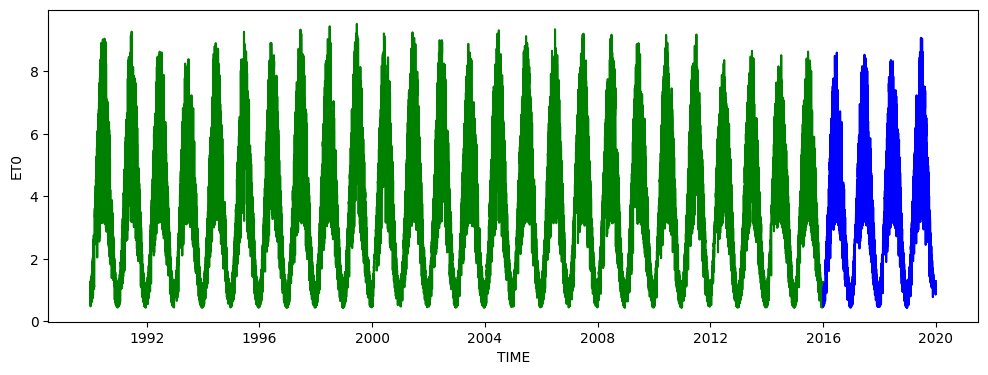

In [74]:
fig = py.figure(figsize=(10, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

subData = data.loc[:"2015-12-31"]
N = len(subData)
x = subData.index
y = subData["ET0"]
ax.plot(x, y, color='green')


ax.set_xlabel("TIME")
ax.set_ylabel("ET0")


subData_cross = data.loc["2016":]
N_cross = len(subData_cross)
x_cross = subData_cross.index
y_cross = subData_cross["ET0"]
ax.plot(x_cross, y_cross, color='blue')

# subData_test = data.loc["2019":]
# N_test = len(subData_test)
# x_test = subData_test.index
# y_test = subData_test["ET0"]
# ax.plot(x_test, y_test, color='black')


In [75]:
nDelay = 8

N = len(y)
XS = np.zeros((N-nDelay, nDelay))
ys = np.zeros(N-nDelay)
for i in range(0, N-nDelay):
  XS[i,:] =  y[i:i+nDelay]
  ys[i] = y[i+nDelay]


N_cross = len(y_cross)
XS_cross = np.zeros((N_cross-nDelay, nDelay))
ys_cross = np.zeros(N_cross-nDelay)
for i in range(0, N_cross-nDelay):
  XS_cross[i,:] =  y_cross[i:i+nDelay]
  ys_cross[i] = y_cross[i+nDelay]



In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(max_depth=100, n_estimators=10000, \
        max_features=5, min_samples_leaf=3, \
            bootstrap=True, min_samples_split=2)

regr.fit(XS, ys)

KeyboardInterrupt: ignored

In [ ]:
import xgboost as xgb

t1 = datetime.now()
n_trees  = 1000
max_depth = 10
learning_rate = 0.01

xgbr = xgb.XGBRegressor(n_estimators = n_trees, max_depth = max_depth,eta= learning_rate)
xgbr.fit(XS, ys)

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

p_ys_cross  = xgbr.predict(XS_cross)


In [76]:
t1 = datetime.now()
import xgboost as xgb


#set up XGBoost 
max_depth = 10
n_trees = 100
learning_rate = 0.01

xgbr = xgb.XGBRegressor(n_estimators = n_trees, max_depth = max_depth, eta = learning_rate, objective='reg:squarederror') 

from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split,RandomizedSearchCV

#choose a set of parameters over which to do the hyperparameter search
xgbr_params_dist = { 'max_depth': sp_randint(3, 50),
          'n_estimators': sp_randint(10, 10000), #10000
           'eta':[0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001] }


#set up the random search
rand_xgbr = RandomizedSearchCV(xgbr, param_distributions = xgbr_params_dist, n_iter = 50, cv=5, 
                                n_jobs = -1, verbose = 10 )
#run the random search
rand_xgbr.fit(XS, ys)

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 41

Execution time:
1:05:29.934394


In [77]:
print("Best xgbr parameters set:")
print(rand_xgbr.best_estimator_)

p_ys_cross  = rand_xgbr.predict(XS_cross)



Best xgbr parameters set:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=9, min_child_weight=1, missing=None, n_estimators=238,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


In [71]:
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb


#set up XGBoost 
max_depth = 6
n_trees = 1700
learning_rate = 0.1

xgbr = xgb.XGBRegressor(n_estimators = n_trees, max_depth = max_depth, eta = learning_rate, objective='reg:squarederror') 


kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, XS, ys, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())


K-fold CV average score: 0.14


In [27]:
importances = regr.feature_importances_
print('Feature Importances: ', importances)



Feature Importances:  [0. 0. 0. 0. 0. 0. 0. 0.]


In [65]:
p_ys_cross  = regr.predict(XS_cross)


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

RMSE = mean_squared_error(ys_cross, p_ys_cross, squared=False)
R2 = r2_score(ys_cross, p_ys_cross)

print(RMSE, R2)

IndexError: ignored

In [66]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
z_cross = subData_cross["ET1"]

N_cross = len(z_cross)
zs_cross = np.zeros(N_cross-nDelay)
for i in range(0, N_cross-nDelay):
  zs_cross[i] = z_cross[i+nDelay]

In [78]:
r2_score(ys_cross, p_ys_cross)

0.7024177239162301

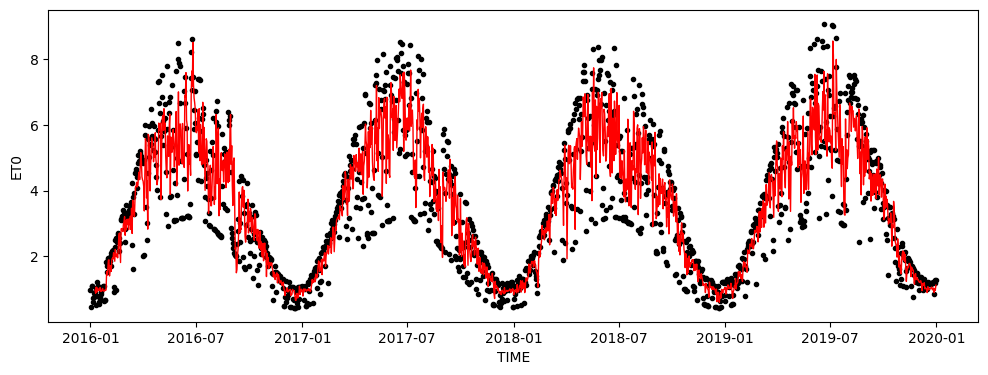

In [79]:
fig = py.figure(figsize=(10, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)




ax.set_xlabel("TIME")
ax.set_ylabel("ET0")


y_cross = subData_cross["ET0"]
ax.plot(x_cross, y_cross, 'k.')

ax.plot(x_cross[8:], p_ys_cross, 'r-', linewidth=1)
